<a href="https://colab.research.google.com/github/chunlam-chan/quantum-coding-samples/blob/main/qaoa_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QAOA for MIMO Detection, Part 3: Non-binary Discrete Optimization

In this notebook, we extend our exploration of QAOA to address non-binary discrete optimization. We continue to focus on MIMO detection as our toy example. However, unlike the binary optimization problems considered in Part 1 and Part 2, we now switch to consider signals encoded using Quadrature Amplitude Modulation (QAM), where variables are discrete but not limited to binary values. The primary goal of this investigation is to assess the efficacy of QAOA for non-binary discrete optimization problems.

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

In [ ]:
try:
    import pennylane as qml
except ImportError as e:
    # Install pennylane if package is not already installed
    !pip install pennylane
    import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from matplotlib import pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from time import perf_counter

np.random.seed(2023)
plt.style.use('seaborn-v0_8')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


### Quadrature Amplitude Modulation (QAM) Signals

In $M$-QAM where $M=2^{2k}$ and $k \in \mathbb{Z}_{+}$, a binary bit sequence (consisting of $2k$ bits) is mapped to a specific symbol from a constellation of $M$ complex points, denoted as $x(b_1, b_2, \ldots, b_{2k}) \in \mathbb{C}$. These constellation points can be indexed by integers, and we refer to these integers as symbols. Each symbol represents a unique combination of bits, allowing the transmission of multiple bits simultaneously.

Let's take 16-QAM as our example. The Gray mapping process involves considering $z_i = 1 - 2b_i \in \{-1, 1\}$, and then obtaining the constellation point (which is a complex number) with the equation $x(b_1, b_2, b_3, b_4) = (z_4 z_2 + 2z_2) + i(z_3 z_1 + 2z_1)$. We can visualize all the constellation points on a complex plane below.

In [ ]:
qam = 16
bits_per_symbol = int(np.log2(qam))

print(f'bits per symbol = {bits_per_symbol}')

bits per symbol = 4


In [ ]:
def get_constellation(s:str):
  bits_int = [int(i) for i in s]
  z = [1 - 2*b for b in bits_int]
  x_real = z[3]*z[1] + 2*z[1]
  x_imag = z[2]*z[0] + 2*z[0]
  return x_real + x_imag * 1j

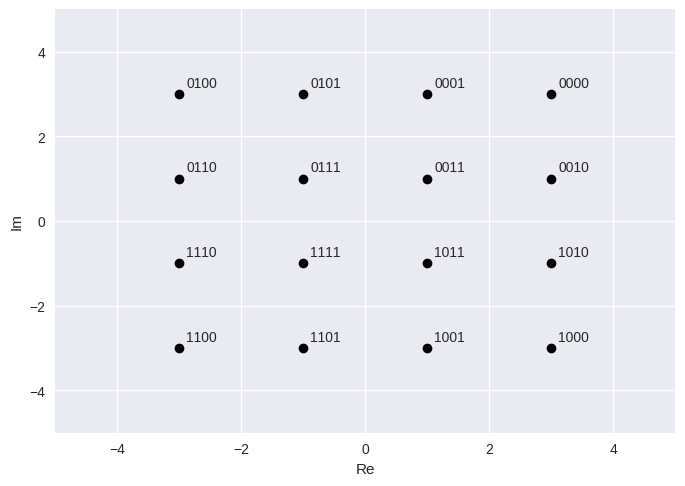

In [ ]:
bitstring_list = [np.binary_repr(i, width=4) for i in range(16)]
constellations = {bitstring: get_constellation(bitstring) for bitstring in bitstring_list}

for bitstring, x in constellations.items():
  x_re = np.real(x)
  x_im = np.imag(x)
  plt.plot(x_re, x_im, 'ko', label=bitstring)
  plt.annotate(bitstring, (x_re, x_im), xytext=(5, 5), textcoords='offset points')
plt.xlabel('Re')
plt.ylabel('Im')
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.grid(True)
plt.show()

As seen above, the 16 constellation points are evenly spaced on the complex plane, forming the set $\mathcal{X}$.

Now, let's recall the inference model we are tackling here: the received signal vector $y \in \mathbb{C}^M$ is a linear transform of $x \in \mathcal{X}^N$, perturbed by an additive noise $n$, given by the equation $y = Hx + n$; we want to infer $x$ from $y$.
For the purpose of focusing on the effect of the non-binary set $\mathcal{X}$, we simplify other aspects of the model. In our considerations, $H$ is a real matrix like in the previous notebooks, and we assume a noiseless case where $n=0$.

In [ ]:
def gen_instance(M, N, noise_var=0):
  H = np.random.randn(M, N)
  x_symbols = np.random.randint(16, size=M)
  x_bits = [bitstring_list[s] for s in x_symbols]
  x = np.fromiter(map(get_constellation, x_bits), dtype=np.complex128)
  z = np.sqrt(noise_var) * np.random.randn(M)
  y = H @ x + z
  return x_symbols, x_bits, x, H, y

In this noiseless case, if $H$ is additionally a square matrix, we can recover $x$ simply by using $H^{-1}y$. As a result, this problem can be solved classically in polynomial time. We can do a quick sanity check on this classical solution. Despite its efficient classical solution, we still aim to test the efficacy of using QAOA to address this problem.

In [ ]:
M, N = 2, 2
x_symbols, x_bits, x, H, y = gen_instance(M, N)

In [ ]:
print('A sanity check:')
print(f'x = {x}')
print(f'inv(H) @ y = {np.linalg.inv(H) @ y}')

A sanity check:
x = [-3.+3.j -3.+1.j]
inv(H) @ y = [-3.+3.j -3.+1.j]


### Encoding the Problem for QAOA

To encode the problem for QAOA, we need to transform the model from complex numbers to real numbers. This can be done by noting that $\Vert y - Hx \Vert^2 = \Vert \tilde{y} - \tilde{H}\tilde{x} \Vert^2$ where $$\tilde{H} = \begin{bmatrix} \text{Re}(H) & -\text{Im}(H) \\ \text{Im}(H) & \text{Re}(H) \end{bmatrix}, \quad \tilde{x} = \begin{bmatrix} \text{Re}(x) \\ \text{Im}(x) \end{bmatrix}, \quad \tilde{y} = \begin{bmatrix} \text{Re}(y) \\ \text{Im}(y) \end{bmatrix}.$$
Therefore, we can simply express $x_{ML} \triangleq \min_{x \in \mathcal{X}^N} \Vert y - Hx \Vert^2$ in a form similar to what appeared in Part 1, which is $x_{ML} = \min_{x \in \mathcal{X}^N} f(x)$ where
$$f(x) = \sum_{i<j}^{2N} A_{i,j} \tilde{x}_i \tilde{x}_j + \frac{1}{2} \sum_{i=1}^{2N} A_{i,i} \tilde{x}_i \tilde{x}_i + \sum_{i=1}^{2N} \tilde{b}_i \tilde{x}_i.$$
Here, $\tilde{A} = 2\tilde{H}^T \tilde{H}$ and $\tilde{b} = -2\tilde{H}^T \tilde{y}$. To further proceed, we recall that $x_i = (z_{i,4} z_{i,2} + 2z_{i,2}) + i(z_{i,3} z_{i,1} + 2z_{i,1})$. The Hamiltonian encoding the problem can then be derived by writing $f(x)$ explicitly in terms of $z = [z_{1,1}, z_{1,2}, \cdots, z_{N,4}]$ through substituting $z$ into $\tilde{x}$, followed by further replacing $z_{i,j}$ with $\sigma_z^{(i,j)}$.

<details>
<summary>Click here for some calculation details</summary>
For example, we have
$$\sum_{i<j}^{2N} A_{i,j} \tilde{x}_i \tilde{x}_j = \sum_{j=2}^{N} \sum_{i=1}^{j-1} A_{i,j} \tilde{x}_i \tilde{x}_j + \sum_{j=1}^{N} \sum_{i=1}^{N} A_{i,N+j} \tilde{x}_{i} \tilde{x}_{N+j} + \sum_{j=2}^{N} \sum_{i=1}^{j-1} A_{N+i,N+j} \tilde{x}_{N+i} \tilde{x}_{N+j}$$
$$ = \sum_{j=2}^{N} \sum_{i=1}^{j-1} A_{i,j} (z_{i,4} z_{i,2} + 2z_{i,2}) (z_{j,4} z_{j,2} + 2z_{j,2}) $$
$$ + \sum_{j=1}^{N} \sum_{i=1}^{N} A_{N+i,j} (z_{i,4} z_{i,2} + 2z_{i,2}) (z_{j,3} z_{j,1} + 2z_{j,1}) $$
$$ + \sum_{j=2}^{N} \sum_{i=1}^{j-1} A_{N+i,N+j} (z_{i,3} z_{i,1} + 2z_{i,1}) (z_{j,3} z_{j,1} + 2z_{j,1}) $$
</details>

This transformation enables us to utilize QAOA to solve the non-binary discrete optimization problem. Whether this transformaion enables the QAOA to solve the problem efficiently will be a task we want to check in the rest of this notebook. We now proceed to implement the Hamiltonian and QAOA circuit, along with some utility functions, in the following code snippets.

In [ ]:
# Compute the cost Hamiltonian and mixer Hamitonian
def mimo_detection_16QAM(H, y):
  H_t = np.block([[np.real(H), -np.imag(H)], [np.imag(H), np.real(H)]])
  y_t = np.block([np.real(y), np.imag(y)])
  A = 2 * H_t.T @ H_t
  b = -2 * y_t.T @ H_t

  obs = []
  coeffs = []

  for j in range(N):
    for i in range(j):
      obs.append(qml.PauliZ(4*i+3) @ qml.PauliZ(4*i+1) @ qml.PauliZ(4*j+3) @ qml.PauliZ(4*j+1))
      coeffs.append(A[i,j].numpy())
      obs.append(qml.PauliZ(4*i+3) @ qml.PauliZ(4*i+1) @ qml.PauliZ(4*j+1))
      coeffs.append(2 * A[i,j].numpy())
      obs.append(qml.PauliZ(4*i+1) @ qml.PauliZ(4*j+3) @ qml.PauliZ(4*j+1))
      coeffs.append(2 * A[i,j].numpy())
      obs.append(qml.PauliZ(4*i+1) @ qml.PauliZ(4*j+1))
      coeffs.append(4 * A[i,j].numpy())

  for i in range(N):
    obs.append(qml.PauliZ(4*i+3))
    coeffs.append(2 * A[i,i].numpy())

  for j in range(N):
    for i in range(N):
      obs.append(qml.PauliZ(4*i+3) @ qml.PauliZ(4*i+1) @ qml.PauliZ(4*j+2) @ qml.PauliZ(4*j))
      coeffs.append(A[i,N+j].numpy())
      obs.append(qml.PauliZ(4*i+3) @ qml.PauliZ(4*i+1) @ qml.PauliZ(4*j))
      coeffs.append(2 * A[i,N+j].numpy())
      obs.append(qml.PauliZ(4*i+1) @ qml.PauliZ(4*j+2) @ qml.PauliZ(4*j))
      coeffs.append(2 * A[i,N+j].numpy())
      obs.append(qml.PauliZ(4*i+1) @ qml.PauliZ(4*j))
      coeffs.append(4 * A[i,N+j].numpy())

  for j in range(N):
    for i in range(j):
      obs.append(qml.PauliZ(4*i+2) @ qml.PauliZ(4*i) @ qml.PauliZ(4*j+2) @ qml.PauliZ(4*j))
      coeffs.append(A[N+i,N+j].numpy())
      obs.append(qml.PauliZ(4*i+2) @ qml.PauliZ(4*i) @ qml.PauliZ(4*j))
      coeffs.append(2 * A[N+i,N+j].numpy())
      obs.append(qml.PauliZ(4*i) @ qml.PauliZ(4*j+2) @ qml.PauliZ(4*j))
      coeffs.append(2 * A[N+i,N+j].numpy())
      obs.append(qml.PauliZ(4*i) @ qml.PauliZ(4*j))
      coeffs.append(4 * A[N+i,N+j].numpy())

  for i in range(N):
    obs.append(qml.PauliZ(4*i+2))
    coeffs.append(2 * A[N+i,N+i].numpy())

  for i in range(N):
    obs.append(qml.PauliZ(4*i+3) @ qml.PauliZ(4*i+1))
    coeffs.append(b[i].numpy())
    obs.append(qml.PauliZ(4*i+1))
    coeffs.append(2 * b[i].numpy())

  for i in range(N):
    obs.append(qml.PauliZ(4*i+2) @ qml.PauliZ(4*i))
    coeffs.append(b[N+i].numpy())
    obs.append(qml.PauliZ(4*i))
    coeffs.append(2 * b[N+i].numpy())

  cost_h = qml.Hamiltonian(coeffs, obs)
  mixer_h = qaoa.x_mixer(wires=range(bits_per_symbol*N))

  return cost_h, mixer_h

In [ ]:
class QAOA:
  def __init__(self, cost_h, mixer_h, N, depth):
    self.cost_h = cost_h
    self.mixer_h = mixer_h
    self.depth = depth
    self.wires = range(N)
    self.dev = qml.device('default.qubit', wires=self.wires)

  def _qaoa_layer(self, gamma, alpha):
    qaoa.cost_layer(gamma, self.cost_h)
    qaoa.mixer_layer(alpha, self.mixer_h)

  def _circuit(self, params):
    for w in self.wires:
      qml.Hadamard(wires=w)
    qml.layer(self._qaoa_layer, self.depth, params[0], params[1])

  def cost_function(self, params):
    @qml.qnode(self.dev)
    def qnode():
      self._circuit(params)
      return qml.expval(self.cost_h)

    return qnode()

  def probability_circuit(self, gamma, alpha):
    @qml.qnode(self.dev)
    def qnode():
      self._circuit([gamma, alpha])
      return qml.probs(wires=self.wires)

    return qnode()

  def draw_circuit(self, gamma, alpha):
    @qml.qnode(self.dev)
    def qnode(gamma, alpha):
      self._circuit([gamma, alpha])
      return qml.probs(wires=self.wires)

    return qml.draw_mpl(qnode, decimals=1, expansion_strategy='device')

  def cost_function_for_scipy(self, params_flat):
    params = params_flat.reshape((2,-1))
    return self.cost_function(params)

### Experimental Results of a Simple Instance
Next, we create a QAOA circuit with depth 3, and optimize the circuit using COBYLA. We can compare the improvement of the cost function per iteration with its lower bound, which can be obtained through evaluation at the state given by the bit representation of the true $x$.

In [ ]:
depth = 3

cost_h, mixer_h = mimo_detection_16QAM(H, y)
qaoa_mimo = QAOA(cost_h, mixer_h, 4*N, depth)

In [ ]:
costs = []

def callback(xk):
    costs.append(qaoa_mimo.cost_function_for_scipy(xk))

params_flat = np.random.randn(2*depth, requires_grad=True)
linear_constraint = LinearConstraint(A=np.eye(2*depth), lb=np.zeros(2*depth), ub=2*np.pi*np.ones(2*depth))
out = minimize(qaoa_mimo.cost_function_for_scipy, x0=params_flat, method='COBYLA', constraints=linear_constraint, callback=callback, options={'maxiter':500})

In [ ]:
wires = range(bits_per_symbol * N)
dev = qml.device('default.qubit', wires=wires)

# Compute the expectation of an observable with respect to a given state
@qml.qnode(dev)
def expectation_value(x_bits, observable):
  x_bits_list = []
  for binary_str in x_bits:
    x_bits_list.extend(int(bit) for bit in binary_str)
  qml.BasisState(x_bits_list, wires=wires)
  return qml.expval(observable)

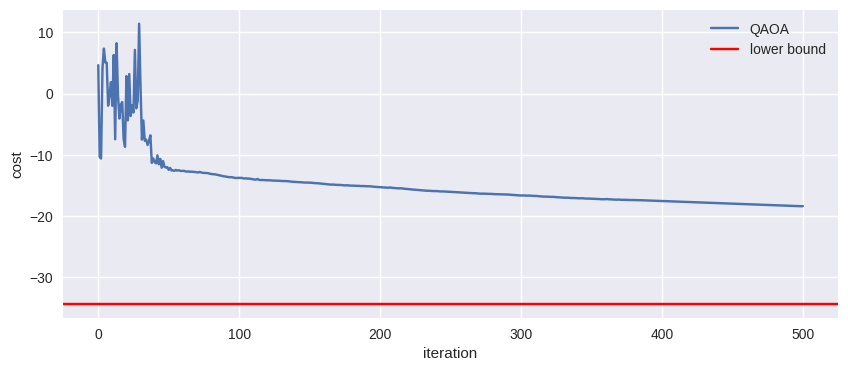

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(range(len(costs)), costs, label='QAOA')
plt.axhline(y=expectation_value(x_bits, cost_h), color='r', linestyle='-', label='lower bound')
plt.xlabel('iteration')
plt.ylabel('cost')
plt.legend()
plt.show()

The cost function starts monotonically decreasing after around 50 iterations. Considering the relatively low circuit depth, it is not surprising that the cost function evaluated by QAOA after many iterations still exhibits a gap compared to the lower bound. Despite not closing the gap, we can still stop the optimization of the circuit after a fixed number of iterations and measure the QAOA circuit in computational basis to obtain the estimated values of $x$ using QAOA. This is carried out below.

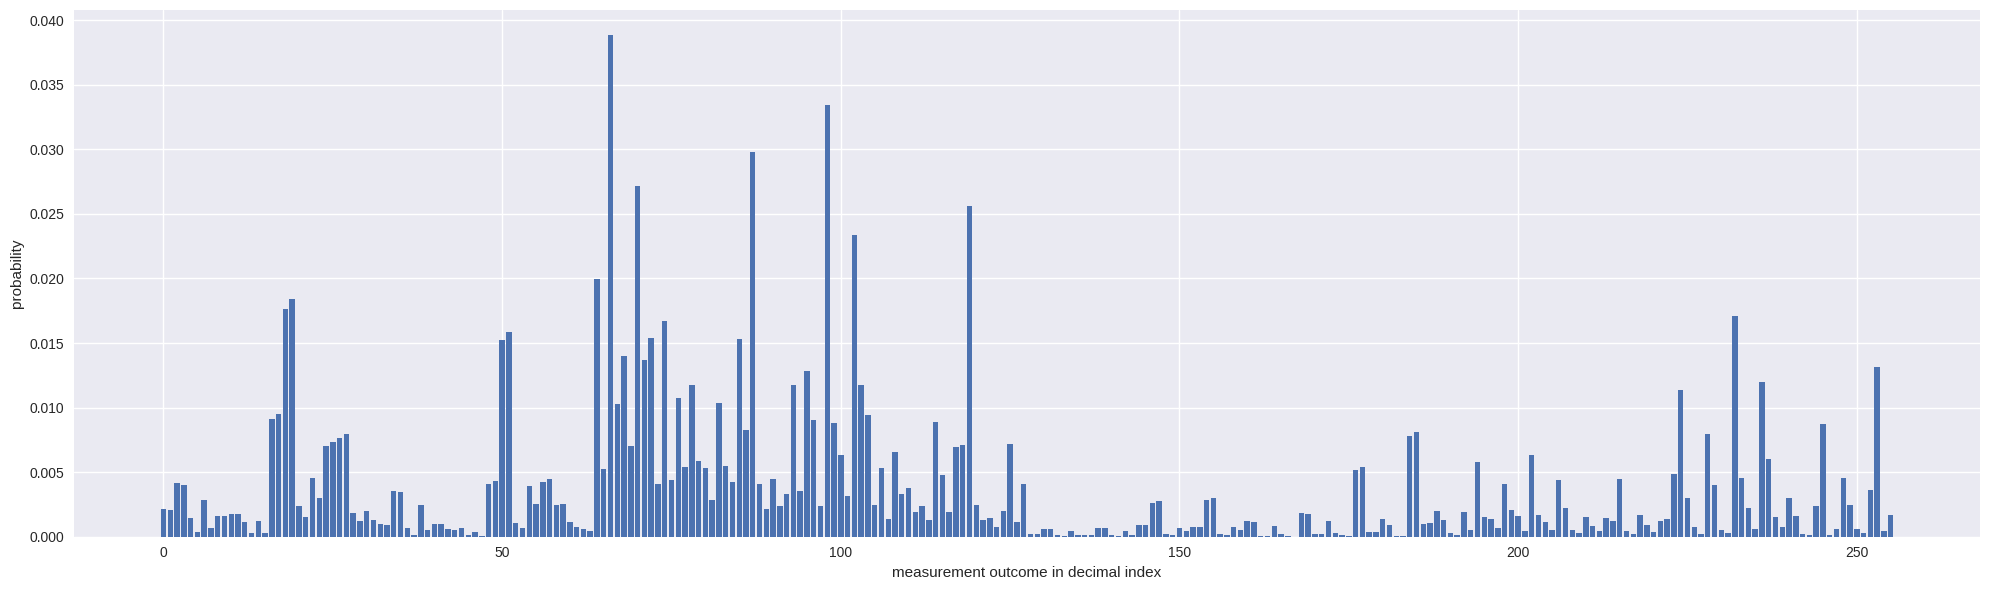

In [ ]:
params_cobyla = out['x'].reshape(2,-1)
probs_cobyla = qaoa_mimo.probability_circuit(params_cobyla[0], params_cobyla[1])

plt.figure(figsize=(20,6))
xlabel = [i for i in range(2 ** len(wires))]
plt.bar(xlabel, probs_cobyla)
plt.xlabel('measurement outcome in decimal index')
plt.ylabel('probability')
plt.tight_layout()
plt.show()

The above shows the empirical distribution of the measurement outcomes. However, the highest peak does not prominently stand out from the others and does not correspond to the true solution perfectly. To futher evaluate the performance, we can also measure the fraction of incorrect symbols and the fraction of incorrect bits, which are commonly referred to as symbol error rate (SER) and bit error rate (BER).

In [ ]:
est_x_idx = np.argmax(probs_cobyla)
est_x_bits_concatenated = np.binary_repr(est_x_idx, N*bits_per_symbol)
est_x_bits = [est_x_bits_concatenated[bits_per_symbol*i:bits_per_symbol*(i+1)] for i in range(N)]
est_x_symbols = [int(est_x_bits[i], 2) for i in range(N)]
est_x = np.array([get_constellation(bits) for bits in est_x_bits])

success = est_x_bits == x_bits
ser = np.sum(est_x_symbols != x_symbols) / N
x_bits_concatenated = ''.join(x_bits)
ber = np.sum([b1 != b2 for b1, b2 in zip(x_bits_concatenated, est_x_bits_concatenated)]) / (N * bits_per_symbol)

print('============== true ==============')
print(f'true bits: {x_bits}')
print(f'true symbols: {x_symbols}')
print(f'true x: {x}')

print('============== est ===============')
print(f'estimated bits: {est_x_bits}')
print(f'estimated symbols: {est_x_symbols}')
print(f'estimated x: {est_x}')

print('============ summary =============')
print(f'success = {success}')
print(f'symbol error rate = {ser}')
print(f'bit error rate = {ber}')

============== true ==============
true bits: ['0100', '0110']
true symbols: [4 6]
true x: [-3.+3.j -3.+1.j]
============== est ===============
estimated bits: ['0100', '0010']
estimated symbols: [4, 2]
estimated x: [-3.+3.j  3.+1.j]
============ summary =============
success = False
symbol error rate = 0.5
bit error rate = 0.125


The above summary shows that both SER and BER are not satisfactory. Let's see if increasing the depth would improve the performance.

### Impact of Circuit Depth on Performance

To proceed, we wrap the previous code in functions and run them for different circuit depths. For subsequent experiments when we need to optimize a QAOA circuit, we will limit the number of iterations to 100 for improved time efficiency.

In [ ]:
def qaoa_experiment(M, N):
  x_symbols, x_bits, x, H, y = gen_instance(M, N)
  cost_h, mixer_h = mimo_detection_16QAM(H, y)
  qaoa_mimo = QAOA(cost_h, mixer_h, 4*N, depth)

  params_flat = np.random.randn(2*depth, requires_grad=True)
  linear_constraint = LinearConstraint(A=np.eye(2*depth), lb=np.zeros(2*depth), ub=2*np.pi*np.ones(2*depth))
  out = minimize(qaoa_mimo.cost_function_for_scipy, x0=params_flat, method='COBYLA', options={'maxiter':100})
  params_cobyla = out['x'].reshape(2,-1)
  probs_cobyla = qaoa_mimo.probability_circuit(params_cobyla[0], params_cobyla[1])

  est_x_idx = np.argmax(probs_cobyla)
  est_x_bits_concatenated = np.binary_repr(est_x_idx, N*bits_per_symbol)
  est_x_bits = [est_x_bits_concatenated[bits_per_symbol*i:bits_per_symbol*(i+1)] for i in range(N)]
  est_x_symbols = [int(est_x_bits[i], 2) for i in range(N)]
  est_x = np.array([get_constellation(bits) for bits in est_x_bits])

  success = est_x_bits == x_bits
  ser = np.sum(est_x_symbols != x_symbols) / N
  x_bits_concatenated = ''.join(x_bits)
  ber = np.sum([b1 != b2 for b1, b2 in zip(x_bits_concatenated, est_x_bits_concatenated)]) / (N * bits_per_symbol)

  return success, ser, ber

In [ ]:
M = 2
N = 2

depth_list = [1, 3, 7]
trials = 100
results = []

t0 = perf_counter()

for depth in depth_list:
  print(f'At depth {depth}')

  results_per_depth = []

  for t in range(trials):
    if t % 40 == 0:
      print(f't = {t}')

    success, ser, ber = qaoa_experiment(M, N)
    results_per_depth.append([int(success), ser, ber])

  results.append(results_per_depth)

t1 = perf_counter()

print(f'Execution time on Colab: {(t1 - t0) / 60:.2f} minutes')

At depth 1
t = 0
t = 40
t = 80
At depth 3
t = 0
t = 40
t = 80
At depth 7
t = 0
t = 40
t = 80
Execution time on Colab: 81.02 minutes


Text(0, 0.5, 'BER')

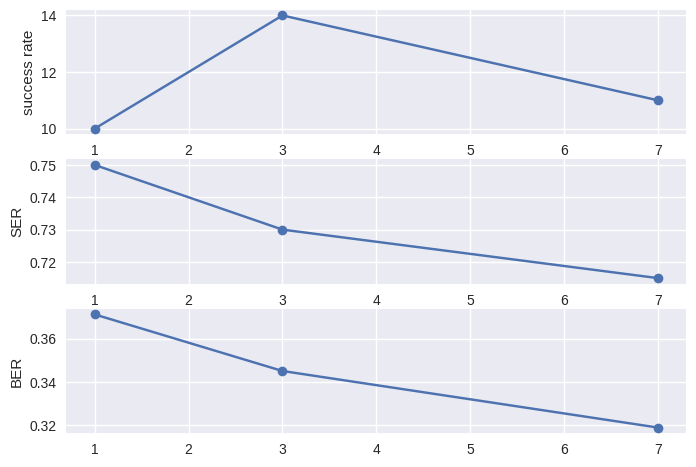

In [ ]:
results_np = np.array(results)

fig, axs = plt.subplots(3)
axs[0].plot(depth_list, np.sum(results_np[:,:,0], axis=-1), '-o')
axs[0].set_ylabel('success rate')
axs[1].plot(depth_list, np.mean(results_np[:,:,1], axis=-1), '-o')
axs[1].set_ylabel('SER')
axs[2].plot(depth_list, np.mean(results_np[:,:,2], axis=-1), '-o')
axs[2].set_ylabel('BER')

In the above experiments, we varied the depth of the circuit up to 7. As expected, higher depths lead to a reduction in both SER and BER. The improvement, however, occurs at a rather slow rate, thus an accurate estimate might happen but only at a high circuit depth. On one hand, this observation reasonably aligns with the "reachability deficit" mentioned in Part 1. On the other hand, considering that the simplified problem here already has an efficient classical solution, it leaves us wondering whether QAOA is a good knife for this particular application or if there might be a more effective way to encode the problem for QAOA.

For the latter suspicion, an arXiv paper [[1]](#[1]) has explored alternative Hamiltonain representations. Although the suggested method can reduce the number of terms in the Hamiltonian by half and thus simplify the QAOA circuit, it requires prior evaluation of the cost function for at least half of the possible configurations of $x$. Essentially, the problem is almost solved before even applying the Hamiltonian encoding and running QAOA.

### Conclusion

Throughout this notebook series, we have explored QAOA and its potential for discrete optimization problems. QAOA has been extensively studied for combinatorial optimization problems such as Max-Cut and $k$-SAT, showing promise in handling binary variables on sparse graphs. In this notebook series, we took a different path, focusing on MIMO detection as a toy problem to eventually explore non-binary discrete optimization on a complete graph.

- In Part 1, we demonstrated QAOA's efficacy for binary optimization, controllable with the circuit depth and choice of classical optimizer.

- In Part 2, we compared QAOA with RQAOA but found that RQAOA did not outperform QAOA for our problem. It might be better suited for certain graph types like sparse graphs.

- In Part 3, we extended our toy problem to non-binary discrete optimization. Despite successful encoding the problem for QAOA, obtaining accurate solutions with reasonable circuit depths posed challenges.

Overall, this notebook series motivates an idea: if QAOA or some other variants achieve quantum advantage for non-binary problems on dense graphs, it will significantly expand applicability of quantum optimization in the NISQ era. Notably, fields like wireless communication could benefit from such advancements.

Last but not least, thanks for reading through this programming journey. I hope you enjoy it.

### References
<a id="references"></a>
<a id="[1]"></a>
1. J. Cui, Y. Xiong, S.X. Ng, L. Hanzo, [*General Hamiltonian Representation of ML Detection Relying on the Quantum Approximate Optimization Algorithm*](https://arxiv.org/abs/2204.05126), arXiv:2204.05126, 2022